In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.spatial import distance, distance_matrix


In [261]:

class GrayScott:
    def __init__(self,type, n, Du, Dv, F, k):
        self.n = n
        self.type = type
        self.Du = Du
        self.Dv = Dv
        self.F = F
        self.k = k
        self.u, self.v = self.init()
        self.utot,self.vtot = [],[]
        self.mor_u = []

    def init(self):
        if self.type == 'Mufano':
            u = np.ones((self.n + 2, self.n + 2))
            v = np.zeros((self.n + 2, self.n + 2))
            x, y = np.meshgrid(np.linspace(0, 1, self.n + 2), np.linspace(0, 1, self.n + 2))

            for _ in range(self.n):  # Generate n random rectangles
                rect_x = np.random.randint(1, self.n + 1)  # Random x-coordinate for the rectangle
                rect_y = np.random.randint(1, self.n + 1)  # Random y-coordinate for the rectangle
                
                # Assign random concentrations within the rectangle
                u[rect_x:rect_x+2, rect_y:rect_y+2] = np.random.uniform(0, 0.5)
                v[rect_x:rect_x+2, rect_y:rect_y+2] = np.random.uniform(0, 0.5)
            return u, v
        else:
            u = np.ones((self.n + 2, self.n + 2)) * 0.5
            v = np.zeros((self.n + 2, self.n + 2)) 
            x, y = np.meshgrid(np.linspace(0, 1, self.n + 2), np.linspace(0, 1, self.n + 2))
            mask = (0.45 < x) & (x < 0.55) & (0.45 < y) & (y < 0.55)
            v[mask] = 0.25
            return u, v
            

    def periodic_bc(self, u):
        u[0, :] = u[-2, :]
        u[-1, :] = u[1, :]
        u[:, 0] = u[:, -2]
        u[:, -1] = u[:, 1]

    def laplacian(self, u):
        return (u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4*u[1:-1, 1:-1])

    def numpy_grayscott(self, U, V, Du, Dv, F, k, dt):
        Lu = self.laplacian(U)
        Lv = self.laplacian(V)
        uvv = U[1:-1, 1:-1]*V[1:-1, 1:-1]*V[1:-1, 1:-1]
        U[1:-1, 1:-1] += dt*(Du*Lu - uvv + F*(1 - U[1:-1, 1:-1]))
        V[1:-1, 1:-1] += dt*(Dv*Lv + uvv - (F + k)*V[1:-1, 1:-1])
        self.periodic_bc(U)
        self.periodic_bc(V)
        return U, V
    
    def run(self, max_time, dt):
        self.u, self.v = self.init()

        for _ in np.arange(0, max_time, dt):
            self.u, self.v = self.numpy_grayscott(self.u, self.v, self.Du, self.Dv, self.F, self.k, dt)
            self.utot.append(np.sum(self.u))
            self.vtot.append(np.sum(self.v))

    def plot(self, max_time: float, dt: float, tickstep: float, savefig: bool):
    
        self.run(max_time, dt)

        plt.figure(figsize=(8.5, 7))
        ax = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
        ax.invert_yaxis()
        ax.tick_params(left=True, bottom=True)
        ax.set_xticks(range(0, self.n + tickstep, tickstep))
        ax.set_yticks(range(0, self.n + tickstep, tickstep))
        ax.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
        ax.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label("Concentration u", fontsize=20)
        ax.set_title(f'F={self.F}, K = {self.k}',fontsize=20)
        plt.tight_layout()

        if savefig:
            plt.savefig(f"/GS_end.png", dpi=300, bbox_inches='tight')
    
    def gif(self, max_time: float, dt: float, tickstep: float):
        self.u, self.v = self.init()

        for _ in np.arange(0, max_time, dt):
            self.u, self.v = self.numpy_grayscott(self.u, self.v, self.Du, self.Dv, self.F, self.k, dt)
            self.utot.append(np.sum(self.u))
            self.vtot.append(np.sum(self.v))


            plt.tight_layout()
            if _ % 100 == 0:
                plt.figure(figsize=(8.5, 7))
                ax = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
                ax.invert_yaxis()
                ax.tick_params(left=True, bottom=True)
                ax.set_xticks(range(0, self.n + tickstep, tickstep))
                ax.set_yticks(range(0, self.n + tickstep, tickstep))
                ax.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                ax.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                cbar = ax.collections[0].colorbar
                cbar.ax.tick_params(labelsize=20)
                cbar.set_label("concentration u", fontsize=20)
                ax.set_title(f'F={self.F},k={self.k}')
                plt.savefig(f"gif_zi/GSF{_}.png", dpi=300, bbox_inches='tight')
            plt.close()

    def concentration(self,t):
        plt.plot(np.arange(0,t,1),self.utot,label='Concentration u')
        plt.plot(np.arange(0,t,1),self.vtot,label= 'Concentration v')
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(self.utot,self.vtot,label='Phase Space')
        plt.xlabel('concentration u')
        plt.ylabel('concentration v')
        plt.legend()
        plt.show()

    def complexity(self,t,dt,multiplot,savefig):
        def split_single(a, n_subs):
            l = n_subs
            means = []
            m, n = a.shape
            b = np.zeros_like(a)
            for i in range(l):
                for j in range(l):
                    i0 = i * int(m/l)
                    i1 = (i + 1) * int(m/l)
                    j0 = j * int(n/l)
                    j1 = (j + 1) * int(n/l)
                    sub_a = a[i0:i1, j0:j1]
                    b[i0:i1, j0:j1] = np.mean(sub_a)

            return b

        def create_T(a, n_subs):
            x = np.zeros((len(n_subs), a.shape[0], a.shape[1]))
            for i, n_sub in enumerate(n_subs[::-1]):
                a = split_single(a, n_sub)
                x[i] = a.copy()
            return x

        def calc_C_O(T): 
            C, O = [], []
            for k in range(1, len(T)):
                O_k = 1/2 * (T[k] - T[k-1]) * (T[k] - T[k-1])
                O.append(O_k)

                C_k = np.abs(np.sum(O_k[k-1]))
                C.append(C_k)

            return np.sum(C), O
        n_subs = [2, 4, 8, 16, 32, 64, 128, 256]
        C_l,O_l = [],[]
        tickstep = 64
        self.u, self.v = self.init()
        for _ in np.arange(0, t, dt):
            self.u, self.v = self.numpy_grayscott(self.u, self.v, self.Du, self.Dv, self.F, self.k, dt)
            if _ % 100 == 0:
                T = create_T(self.u,n_subs)
                C, O = calc_C_O(T)
                O_l.append(O)
                C_l.append(C)


                if multiplot:
                    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
                    ax2 = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
                    ax2.invert_yaxis()
                    ax2.tick_params(left=True, bottom=True)
                    ax2.set_xticks(range(0, self.n + tickstep, tickstep))
                    ax2.set_yticks(range(0, self.n + tickstep, tickstep))
                    ax2.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                    ax2.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                    cbar = ax2.collections[0].colorbar
                    cbar.ax.tick_params(labelsize=20)
                    cbar.set_label("Concentration u", fontsize=20)
                    ax2.set_title(f'F={self.F}, K = {self.k}',fontsize=20)
                    
                    ax1.plot(C_l)
                    ax1.set_xticks(np.arange(0,110,10))
                    ax1.set_yticks(np.arange(0,12.5,2.5))
                    ax1.set_xlabel("Iterations (N/100)",fontsize=20)
                    ax1.set_ylabel("Complexity",fontsize=20)
                    ax1.set_title('Multiscale Complexity',fontsize=20)
                    if savefig:
                        plt.savefig(f"Runs/{self.type}t" + str(_).zfill(4) + ".png", dpi=300, bbox_inches='tight')
                    plt.close()
                else:
                    fig,ax = plt.figure(figsize=(16,16))
                    ax1 = sns.heatmap(self.u, cmap='jet', vmin=0, vmax=1)
                    ax1.invert_yaxis()
                    ax1.tick_params(left=True, bottom=True)
                    ax1.set_xticks(range(0, self.n + tickstep, tickstep))
                    ax1.set_yticks(range(0, self.n + tickstep, tickstep))
                    ax1.set_xticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                    ax1.set_yticklabels([f'{c}' for c in np.arange(0, self.n + tickstep, tickstep)], fontsize=20)
                    cbar = ax1.collections[0].colorbar
                    cbar.ax.tick_params(labelsize=20)
                    cbar.set_label("Concentration u", fontsize=20)
                    ax1.set_title(f'F={self.F}, K = {self.k}',fontsize=20)
                    plt.savefig(f"Runs/Heatmap" + str(_).zfill(4) + ".png",dpi=300,bbox_inches='tight')
                    plt.close()
                    fig, ax = plt.figure()
                    ax1.plot(C_l)
                    ax1.set_xticks(np.arange(0,110,10))
                    ax1.set_yticks(np.arange(0,10,2.5))
                    ax1.set_xlabel("Iterations (N/100)",fontsize=20)
                    ax1.set_ylabel("Complexity",fontsize=20)
                    ax1.set_title('Multiscale Complexity',fontsize=20)
                    if savefig:
                        plt.savefig(f"Runs/Multiscale" + str(_).zfill(4) + ".png",dpi=300,bbox_inches='tight')
                    plt.close()
        return C_l,O_l


In [262]:
t=10000
#gs = GrayScott(n=256, type ='Pearson', Du=0.090, Dv=0.03, F=0.018, k=0.055)
gs_M = GrayScott(n=512,type='Mufano', Du=0.055, Dv=0.03, F=0.014, k=0.047)   
# C_l,O_l = gs.complexity(t=t,dt=1,multiplot=True,savefig=True)
C_l,O_l = gs_M.complexity(t=t,dt=1,multiplot=True,savefig=True)

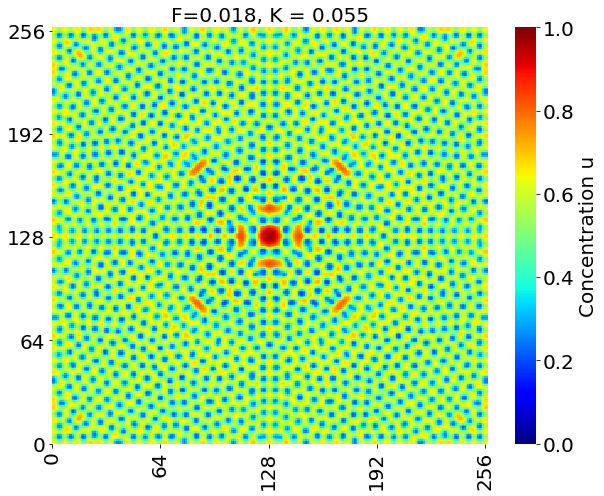

In [250]:
gs.plot(max_time =t, dt=1, tickstep=64, savefig=False)
gs_M.plot(max_time = t, dt=1,tickstep=128, savefig=False) 